# Comparison with Snorkel

Shows differences with the flippers label model and the snorkel model.
To run this notebooks, it is required to !pip install snorkel

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

os.chdir("..")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.calibration as calibration
import sklearn.metrics as metrics
import torch

import flippers

# Loading benchmarks from `wrench`

`wrench` is an open source weak supervision benchmark and library created by Jieyu Zhang.

To learn more, visit https://github.com/JieyuZ2/wrench

To get the datasets, you will need to run `sh scripts/download_wrench_datasets.sh` from the root of the repository
Or grab them yourself from https://github.com/JieyuZ2/wrench#-available-datasets

In [4]:
# !cat scripts/download_wrench_datasets.sh

# !bash ./scripts/download_wrench_datasets.sh

In [5]:
from examples.utils import load_wrench_dataset, MetricsUtil

Choose your dataset here

In [6]:
datasets = ["cdr", "yelp", "youtube", "census", "spouse", "basketball", "sms", "tennis"]
dataset = "youtube"

data, weak_labels, polarities = load_wrench_dataset(dataset)
train, dev, test = data
L_train, L_dev, L_test = weak_labels

c:\Users\liamt\Repos\flippers\flippers\_core\_core.py:151: UserWarning: Polarity mapping if not furnished.
Make sure L captures all possible values of each weak labelers.
  warnings.warn(


In [7]:
dataset = "cdr"
# dataset = "census"
# dataset = "yelp"
# dataset = "youtube"
# dataset= "semeval"
# dataset = "spouse"


data, weak_labels, polarities = load_wrench_dataset(dataset)
train, dev, test = data
L_train, L_dev, L_test = weak_labels

c:\Users\liamt\Repos\flippers\flippers\_core\_core.py:151: UserWarning: Polarity mapping if not furnished.
Make sure L captures all possible values of each weak labelers.
  warnings.warn(


In [8]:
class_balances = list(
    dev["label"].astype(int).value_counts(normalize=True).sort_index()
)
class_balances

[0.6673913043478261, 0.33260869565217394]

# Brief overview of `flippers`

The following is the weak label matrix binary format used by `flippers`.

All labeling functions are unimodal, either predicting 0 ("Abstain") or a 1.

This is different than some other weak supervision libraries like Snorkel, where Abstains are -1, and other outputs are polarized predictions.

In [9]:
L_train

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8425,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
8426,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8427,0,0,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8428,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [10]:
L_train_snorkel = train["weak_labels"].apply(pd.Series)
L_train_snorkel

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,-1,-1,-1,0,0,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,...,-1,-1,-1,-1,-1,-1,-1,0,-1,-1
2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8425,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,-1,-1,-1,-1,-1,-1,-1,-1,-1
8426,-1,-1,-1,0,0,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
8427,-1,-1,-1,0,0,-1,-1,-1,-1,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
8428,-1,-1,-1,-1,-1,0,-1,-1,-1,-1,...,-1,-1,0,-1,-1,-1,-1,-1,-1,-1


The polarity of a labeling function informs which class it is trying to detect.

We have `#|weak labelers| = L.shape[1] = len(polarities)`

In [11]:
polarities

array([1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int64)

In [12]:
flippers.summary(L_train, polarities)

,polarity,coverage,confidence,overlaps,matches,conflicts
0,1,0.032,1.0,0.028,0.026,0.013
1,1,0.022,1.0,0.018,0.018,0.006
2,1,0.004,1.0,0.004,0.004,0.002
3,0,0.048,1.0,0.048,0.048,0.020
4,0,0.088,1.0,0.087,0.087,0.038
5,0,0.188,1.0,0.170,0.145,0.092
6,0,0.014,1.0,0.014,0.013,0.009
7,1,0.018,1.0,0.018,0.018,0.005
8,1,0.020,1.0,0.020,0.020,0.008
9,0,0.047,1.0,0.047,0.047,0.017


Scoring utils:

In [13]:
y_test = test["label"].astype(int).values
Metrics = MetricsUtil(y_test, L_test)

# Training Label Models

## Majority Vote Model

In [14]:
from flippers.models import Voter

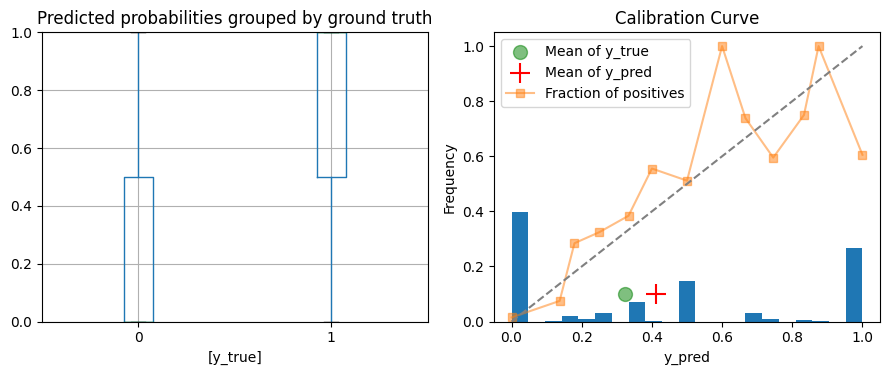

{'F1': 0.613,
 'Average_Precision': 0.59,
 'AUC': 0.828,
 'Accuracy': 0.753,
 'Balanced_Accuracy': 0.714}

In [15]:
preds_vote = Voter(polarities)
Metrics.score(preds_vote, name="MV")

## `flippers`' Snorkel Model

Training a Label Model with Flippers is very simple:

In [16]:
from flippers.models import SnorkelModel

In [17]:
m = SnorkelModel(polarities=polarities, class_balances=class_balances)
m.fit(L_train, learning_rate=5e-3)

### Update priors with votes and abstains

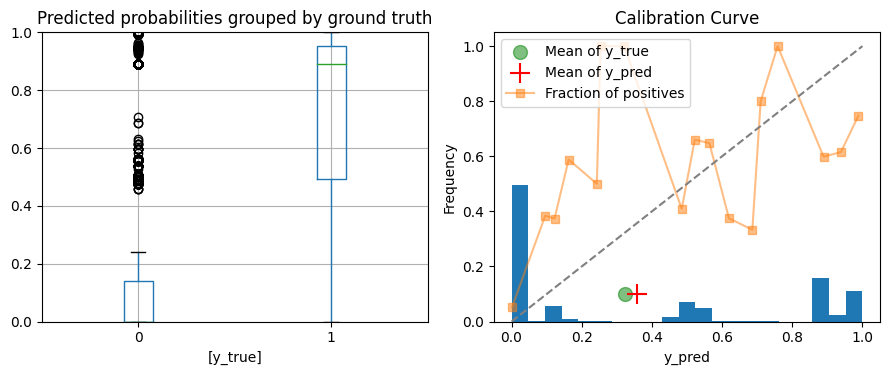

{'F1': 0.702,
 'Average_Precision': 0.67,
 'AUC': 0.862,
 'Accuracy': 0.794,
 'Balanced_Accuracy': 0.782}

In [18]:
# This is the Uniform Marginals calculation the Snorkel and Metal libraries use
# Performance should be very similar to the Snorkel model
Metrics.score(m, name="flippers")

### Ignore abstains in prior update

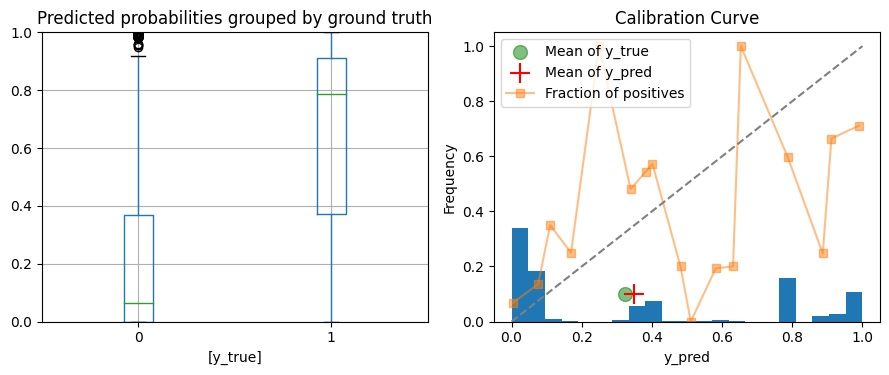

{'F1': 0.611,
 'Average_Precision': 0.624,
 'AUC': 0.813,
 'Accuracy': 0.748,
 'Balanced_Accuracy': 0.713}

In [19]:
# This is the Uniform Marginals calculation the Snorkel and Metal libraries use
# Performance should be very similar to the Snorkel model
# Usually, it is worse than not ignoring the likelihood given by the abstains
Metrics.score(
    m, name="flippers_ignore_abstains", predict_proba_args={"ignore_abstains": True}
)

## Comparison with `Snorkel`'s library label model

In [20]:
# Snorkel is not a dependency for flippers' model as it was rewritten from scracth
#!pip install snorkel

In [21]:
from snorkel.labeling.model.label_model import LabelModel

### LabelModel with class balance priors

Sometimes snorkel can give strange probability distributions without class balance, e.g. cdr dataset

INFO:root:Computing O...
INFO:root:Estimating \mu...
100%|██████████| 100/100 [00:00<00:00, 790.12epoch/s]
INFO:root:Finished Training


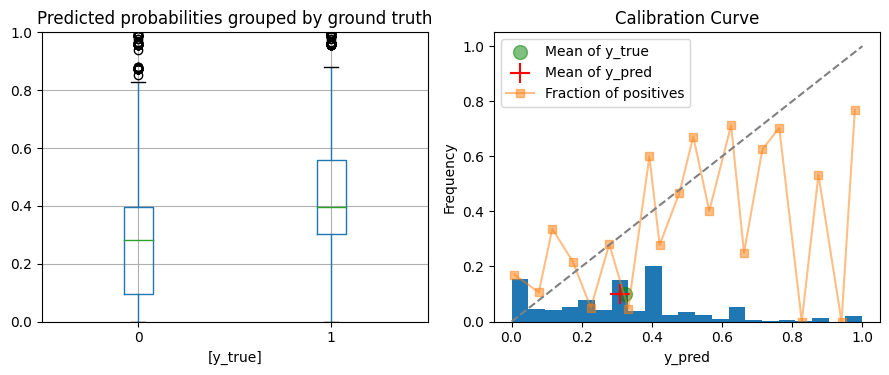

{'F1': 0.42,
 'Average_Precision': 0.554,
 'AUC': 0.716,
 'Accuracy': 0.72,
 'Balanced_Accuracy': 0.614}

In [22]:
sn = LabelModel()
sn.fit(
    train["weak_labels"].apply(pd.Series).values,
    lr=5e-2,
    class_balance=class_balances,
    log_freq=99,
)
Metrics.score(
    y_pred=sn.predict_proba(test["weak_labels"].apply(pd.Series).values)[:, 1],
    name="Snorkel_with_priors",
)

Sometimes Snorkel does not behave well with class balance priors and its better to leave the default uniform value.

### LabelModel without class balance priors

INFO:root:Computing O...
INFO:root:Estimating \mu...
100%|██████████| 100/100 [00:00<00:00, 732.36epoch/s]
INFO:root:Finished Training


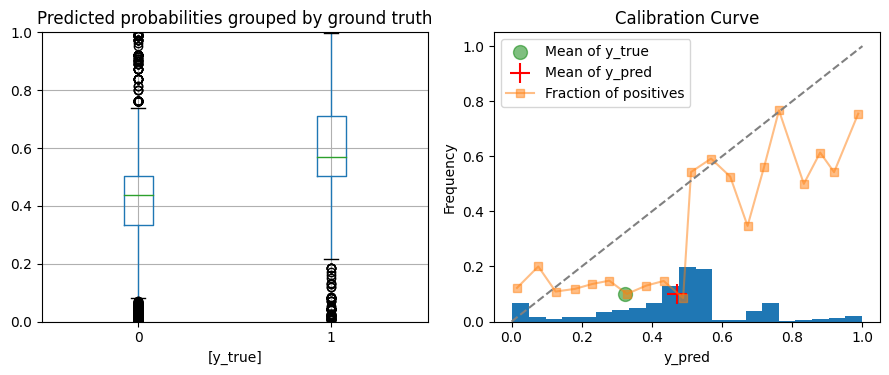

{'F1': 0.678,
 'Average_Precision': 0.598,
 'AUC': 0.771,
 'Accuracy': 0.757,
 'Balanced_Accuracy': 0.765}

In [23]:
sn = LabelModel()
sn.fit(
    train["weak_labels"].apply(pd.Series).values,
    lr=5e-3,
    class_balance=None,
    log_freq=99,
)

Metrics.score(
    y_pred=sn.predict_proba(test["weak_labels"].apply(pd.Series).values)[:, 1],
    name="Snorkel_no_priors",
)

# Final Metric roundup

In [24]:
metrics_df = pd.DataFrame.from_dict(Metrics.metrics).T

In [25]:
metrics_df.style.apply(
    lambda x: ["text-decoration: underline" if v == x.max() else "" for v in x], axis=0
).format("{:.3f}")

,F1,Average_Precision,AUC,Accuracy,Balanced_Accuracy
MV,0.613,0.590,0.828,0.753,0.714
flippers,0.702,0.670,0.862,0.794,0.782
flippers_ignore_abstains,0.611,0.624,0.813,0.748,0.713
Snorkel_with_priors,0.420,0.554,0.716,0.720,0.614
Snorkel_no_priors,0.678,0.598,0.771,0.757,0.765
